In [1]:
%qtconsole

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
import numpy as np
import datetime as dt

In [4]:
df = pd.read_csv('Route 109 2014-05.csv')

In [8]:
def filter_nan_entries(df):
    return df.iloc[np.all(df.notnull(), axis=1)]

def get_journeys(df):    
    journeys = np.split(df, np.where(np.diff(df["STOPSEQUENCE"])<= 0)[0]+1)
    
    return journeys


def get_all_stop_transitions(df):
    journeys = get_journeys(df)
    transitions = set()
    for journey in journeys:        
        transitions.update(list(zip(journey.iloc[:-1]["BUS_STOP_CODE"], journey.iloc[1:]["BUS_STOP_CODE"])))
        
    return transitions


def collade_transition_times(df, dt1, dt2, transition):
    start = transition[0]
    stop = transition[1]
    locs = np.where(np.all(np.asarray([df.iloc[:-1]["BUS_STOP_CODE"] == start,
                                  np.asarray(df.iloc[1:]["BUS_STOP_CODE"] == stop)]), axis=0))
    filtered_dt1 = dt1[locs]
    filtered_dt2 = dt2[locs]
    filtered_dept_time = df.iloc[locs]["OBSERVED_DEPARTURE_TIME"]
    filtered_dist = df.iloc[locs]["SCHEDULEDDISTANCE"]


    times = (filtered_dt1 - filtered_dt2).astype("timedelta64[ms]").astype(int) / 1000.0
       
    
    return list(zip(filtered_dept_time, filtered_dist / times, filtered_dist, times))

def compute_travel_times(df):
    dt1 =  pd.to_datetime(df['OBSERVED_DEPARTURE_TIME']).dt.to_pydatetime()
    dt2 =  pd.to_datetime(df['OBSERVED_ARRIVAL_TIME']).dt.to_pydatetime()
    
    return dt1, dt2
    

def calculate_stop_transition_time(df):
    df = filter_nan_entries(df)
    transitions = get_all_stop_transitions(df)
    
    dt1, dt2 = compute_travel_times(df)    
    
    times = {}
    for transition in transitions:
        times[transition] = collade_transition_times(df, dt1, dt2, transition)
        
    return times


def get_bus_stops(df):
    return set(df["BUS_STOP_CODE"])


def get_bus_stop_occupation_matrix(bs):
    return np.zeros((len(bs), (60 * 24 * 31)))


def split_date(date_str):
    days, time = date_str.split(" ")
    d, mth, y = [int(x) for x in days.split("/")]
    
    h, m, s = [int(x) for x in time.split(":")]
    
    return d, mth, y, h, m, s
    
    

def extract_day_from_timestamp(date_str):
    days, time = date_str.split(" ")
    
    return days
    

def get_time_map(df):
    d, mth, y, h, m, s = split_date(df.iloc[0]["OBSERVED_DEPARTURE_TIME"])
    start_day = pd.Timestamp("{}-{}-{} 00:00:00".format(y, mth, d, h, m))
    d, mth, y, h, m, s = split_date(df.iloc[-1]["OBSERVED_DEPARTURE_TIME"])
    stop_day = pd.Timestamp("{}-{}-{} 23:59:00".format(y, mth, d, h, m))
    
    
    time_map = pd.date_range(start_day, 
                             stop_day, freq='min').tolist()
    
    
    return dict(zip(time_map, range(len(time_map))))

# def matrix_idx(d, h, m, s):
#     idx = (60 * 24) * (d-1) + 60 * h + m
    
#     if np.isnan(idx):
#         1/0
        
#     return idx

def matrix_idx(time_map, date_str):
    d, mth, y, h, m, s = split_date(date_str)
    floored_date_time = pd.Timestamp("{}-{}-{} {}:{}:00".format(y, mth, d, h, m))
    return time_map[pd.Timestamp(floored_date_time)]
    
    

def get_index_slice(arrival_time, dept_time):
    start = matrix_idx(*split_date(arrival_time))
    stop = matrix_idx(*split_date(dept_time))
    
    return slice(start, stop)


def calculate_bus_stop_occupation(df):
    journeys = get_journeys(df)
    bs_1 = journeys[0]["BUS_STOP_CODE"].tolist() 
    bs_2 = journeys[-1]["BUS_STOP_CODE"].tolist()
    
    df = filter_nan_entries(df)
    time_map = get_time_map(df)
    
    mat = get_bus_stop_occupation_matrix(bs_1 + bs_2)
    
#     starts = np.asarray(df.apply(lambda x: matrix_idx(*split_date(x["OBSERVED_ARRIVAL_TIME"])), axis=1))
#     stops = np.asarray(df.apply(lambda x: matrix_idx(*split_date(x["OBSERVED_DEPARTURE_TIME"])), axis=1))
    
    starts = np.asarray(df.apply(lambda x: matrix_idx(time_map, x["OBSERVED_ARRIVAL_TIME"]), axis=1))
    stops = np.asarray(df.apply(lambda x: matrix_idx(time_map, x["OBSERVED_DEPARTURE_TIME"]), axis=1))
    
    bs_direction = df["DIRECTION"] == 1
    
    for i, bus_stop in enumerate(bs_1):
        df_idc = np.where((df["BUS_STOP_CODE"] == bus_stop) & bs_direction)[0]
        start = starts[df_idc]
        stop = stops[df_idc]
        
        for srt, stp in zip(start, stop):        
            mat[i, slice(srt, stp)] += 1
            
    for i, bus_stop in enumerate(bs_2):
        df_idc = np.where((df["BUS_STOP_CODE"] == bus_stop) & ~bs_direction)[0]
        start = starts[df_idc]
        stop = stops[df_idc]
        
        for srt, stp in zip(start, stop):        
            mat[i + len(bs_1), slice(srt, stp)] += 1
    
    return mat, time_map



def get_heat_map(start, stop):
    return np.sum(mat[:, start:stop], axis=1)

In [129]:
df_clean = filter_nan_entries(df)

In [110]:
df

ROUTE  DIRECTION  TRIPNR  UNSCHEDULED SCHEDULEDDEPARTURETIME  \
0         109          1       3            0    01/05/2014 04:15:00   
1         109          1       3            0    01/05/2014 04:16:00   
2         109          1       3            0    01/05/2014 04:17:00   
3         109          1       3            0    01/05/2014 04:19:00   
4         109          1       3            0    01/05/2014 04:20:00   
5         109          1       3            0    01/05/2014 04:21:00   
6         109          1       3            0    01/05/2014 04:23:00   
7         109          1       3            0    01/05/2014 04:23:00   
8         109          1       3            0    01/05/2014 04:24:00   
9         109          1       3            0    01/05/2014 04:26:00   
10        109          1       3            0    01/05/2014 04:27:00   
11        109          1       3            0    01/05/2014 04:28:00   
12        109          1       3            0    01/05/2014 04:29:00   
13        109          1       3            0    01/05/2014 04:30:00   
14        109          1       3            0    01/05/2014 04:31:00   
15        109          1       3            0    01/05/2014 04:32:00   
16        109          1       3            0    01/05/2014 04:33:00   
17        109          1       3            0    01/05/2014 04:34:00   
18        109          1       3            0    01/05/2014 04:35:00   
19        109          1       3            0    01/05/2014 04:36:00   
20        109          1       3            0    01/05/2014 04:37:00   
21        109          1       3            0    01/05/2014 04:39:00   
22        109          1       3            0    01/05/2014 04:40:00   
23        109          1       3            0    01/05/2014 04:42:00   
24        109          1       3            0    01/05/2014 04:43:00   
25        109          1       3            0    01/05/2014 04:43:00   
26        109          1       3            0    01/05/2014 04:45:00   
27        109          1       3            0    01/05/2014 04:45:00   
28        109          1       3            0    01/05/2014 04:46:00   
29        109          1       3            0    01/05/2014 04:47:00   
...       ...        ...     ...          ...                    ...   
378250    109          2     358            0    01/06/2014 01:03:00   
378251    109          2     358            0    01/06/2014 01:04:00   
378252    109          2     358            0    01/06/2014 01:05:00   
378253    109          2     358            0    01/06/2014 01:06:00   
378254    109          2     358            0    01/06/2014 01:06:00   
378255    109          2     358            0    01/06/2014 01:07:00   
378256    109          2     358            0    01/06/2014 01:09:00   
378257    109          2     358            0    01/06/2014 01:10:00   
378258    109          2     358            0    01/06/2014 01:11:00   
378259    109          2     358            0    01/06/2014 01:12:00   
378260    109          2     358            0    01/06/2014 01:13:00   
378261    109          2     358            0    01/06/2014 01:14:00   
378262    109          2     358            0    01/06/2014 01:15:00   
378263    109          2     358            0    01/06/2014 01:16:00   
378264    109          2     358            0    01/06/2014 01:17:00   
378265    109          2     358            0    01/06/2014 01:18:00   
378266    109          2     358            0    01/06/2014 01:19:00   
378267    109          2     358            0    01/06/2014 01:20:00   
378268    109          2     358            0    01/06/2014 01:20:00   
378269    109          2     358            0    01/06/2014 01:21:00   
378270    109          2     358            0    01/06/2014 01:22:00   
378271    109          2     358            0    01/06/2014 01:22:00   
378272    109          2     358            0    01/06/2014 01:23:00   
378273    109          2     358            0   

In [9]:
mat,bs_1, bs_2 = calculate_bus_stop_occupation(df)

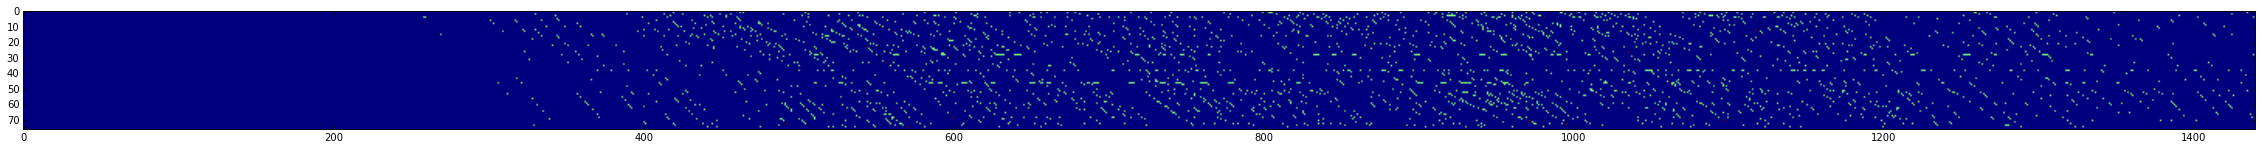

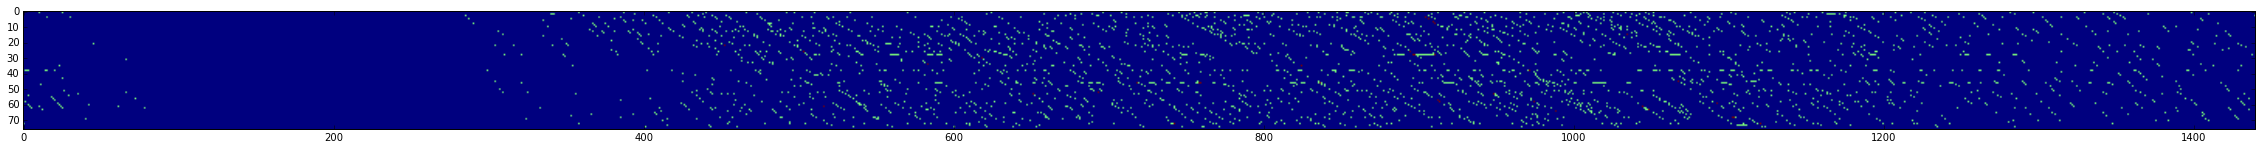

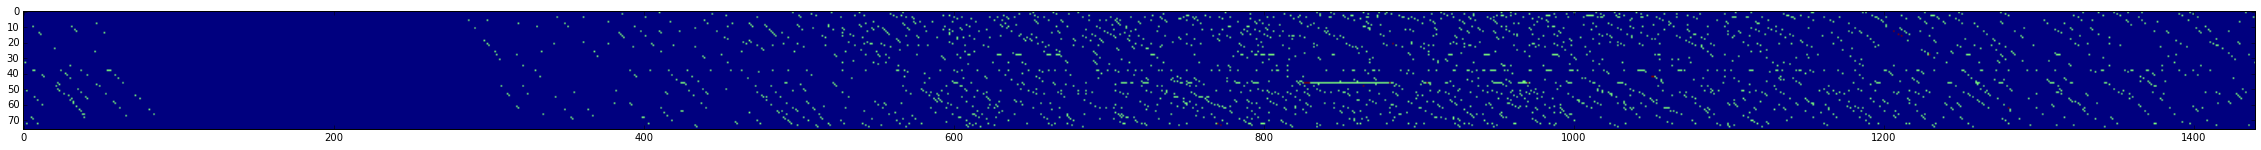

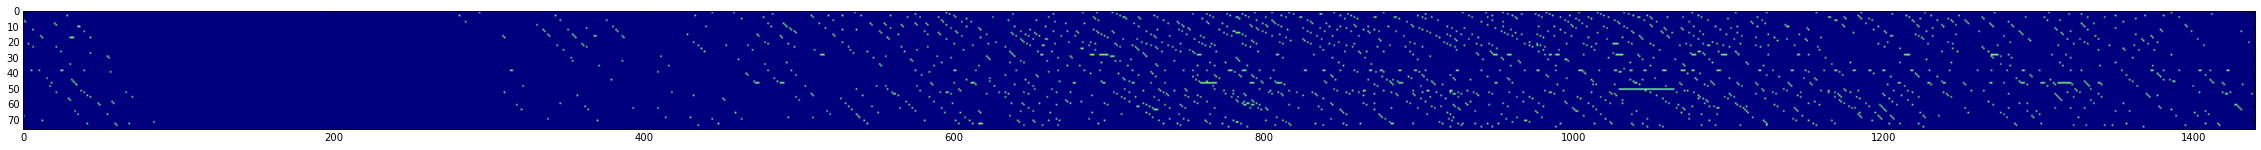

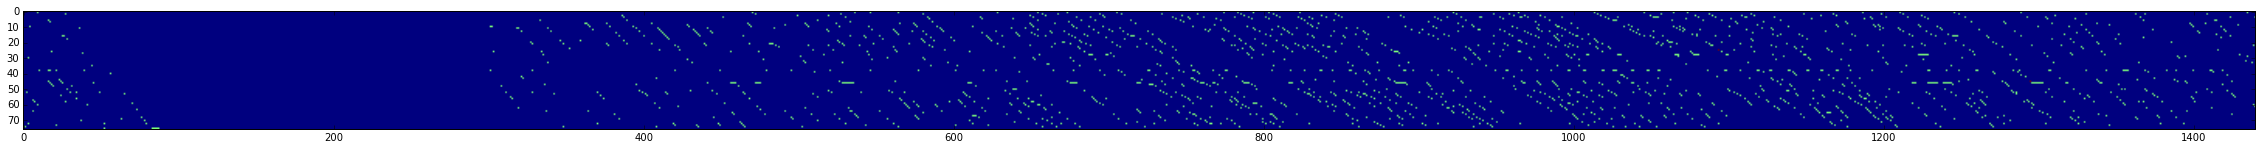

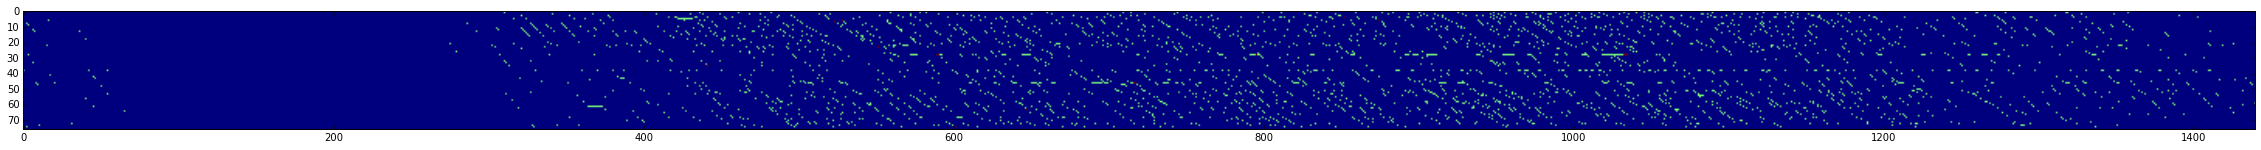

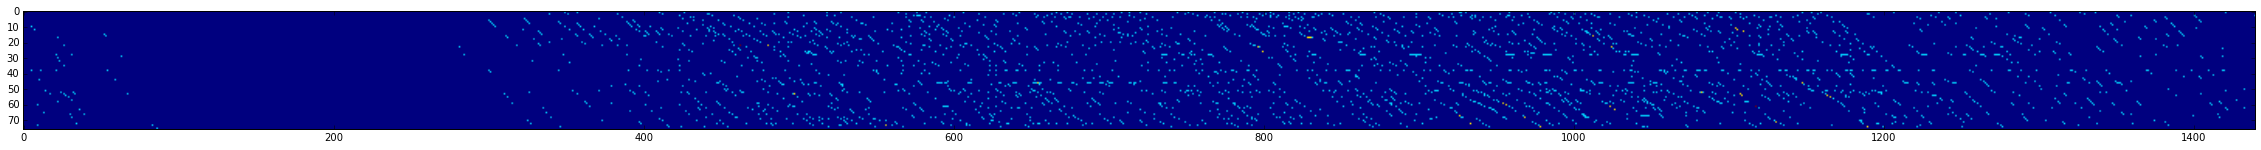

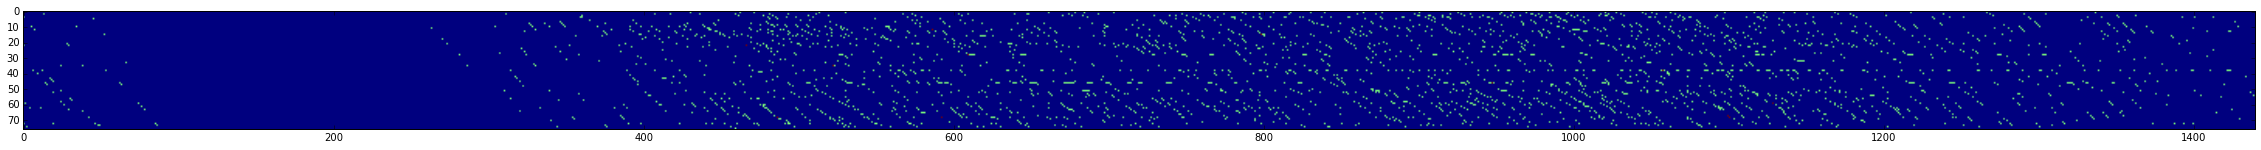

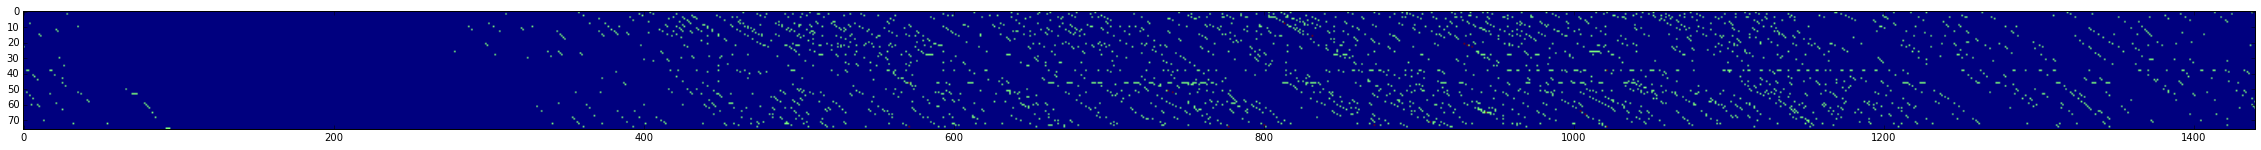

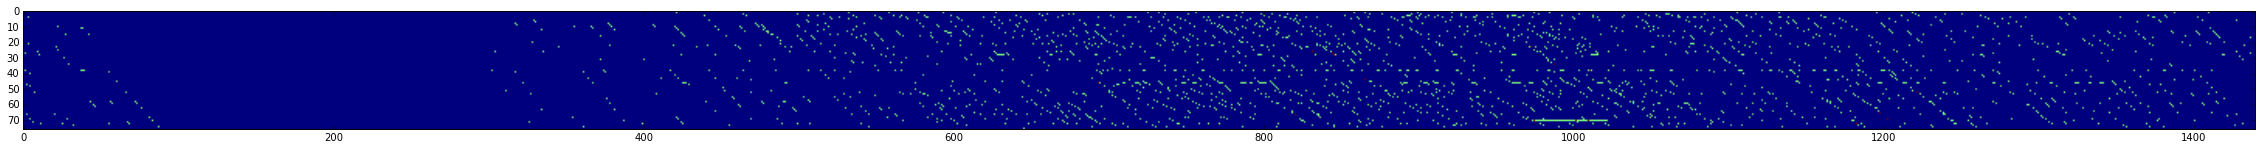

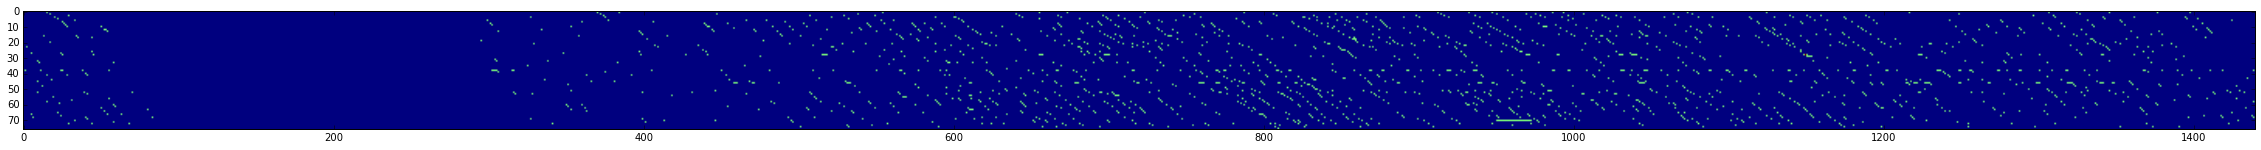

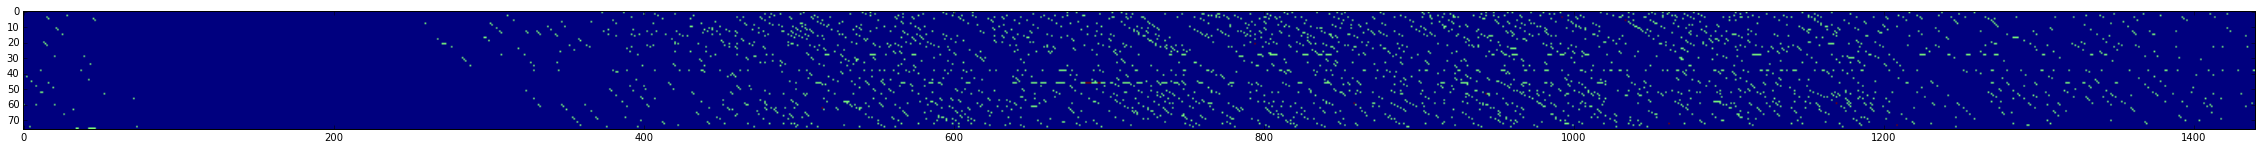

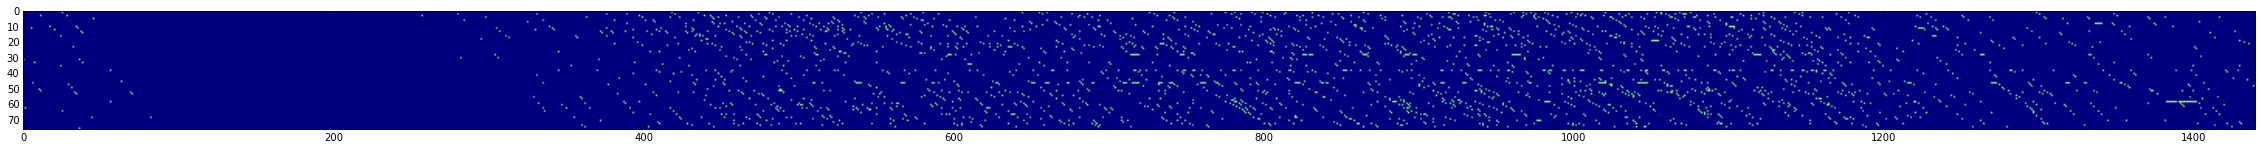

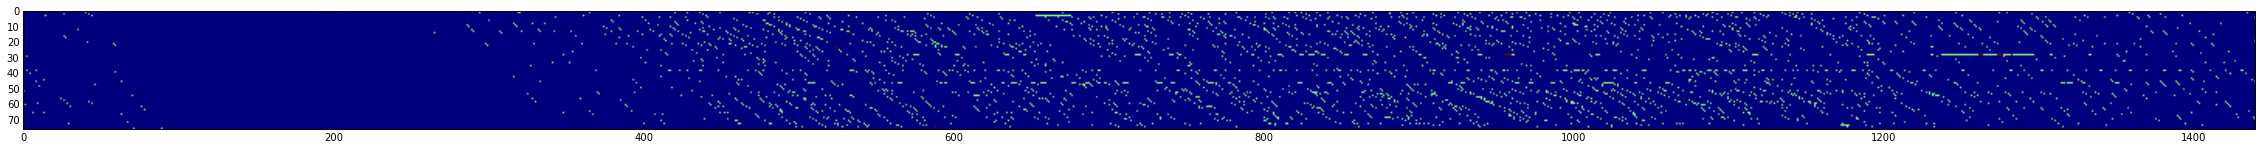

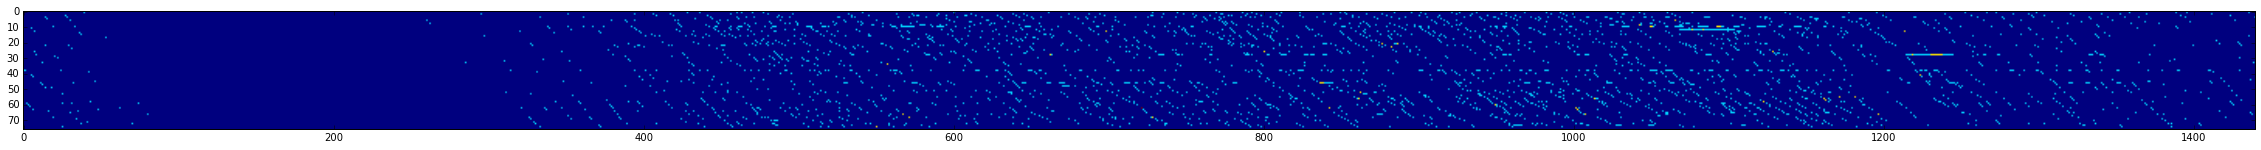

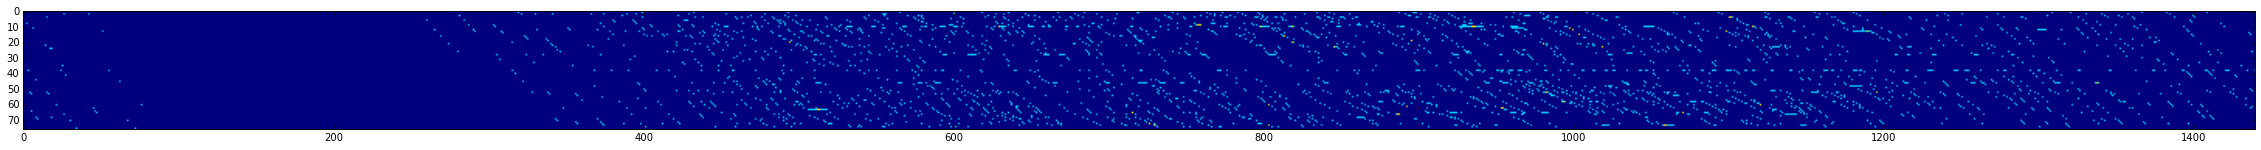

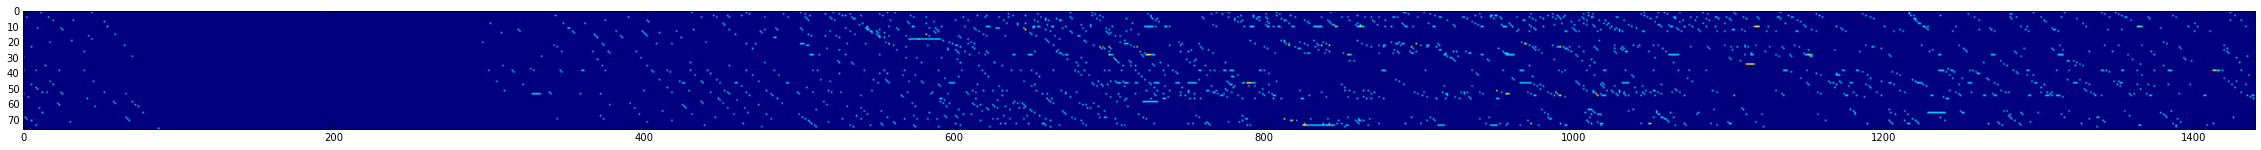

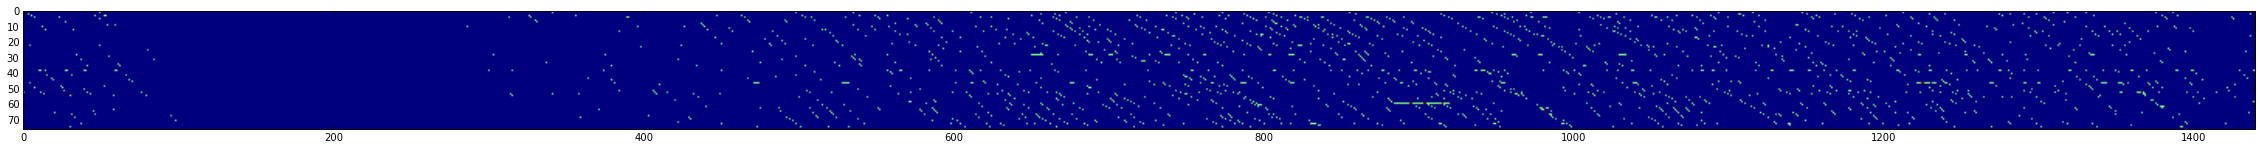

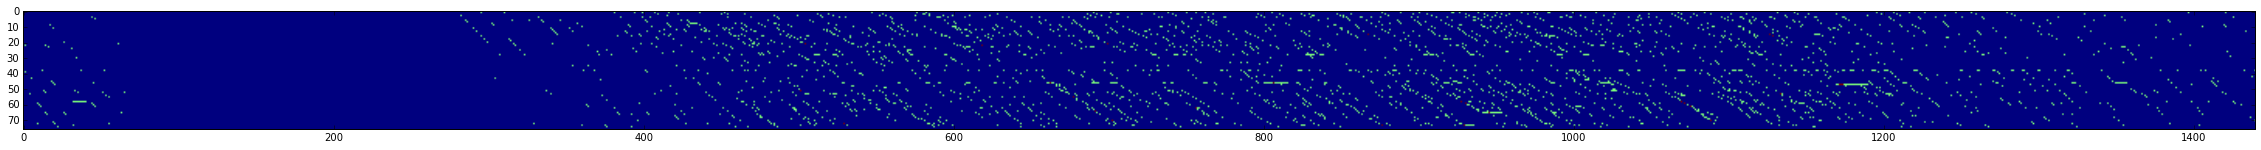

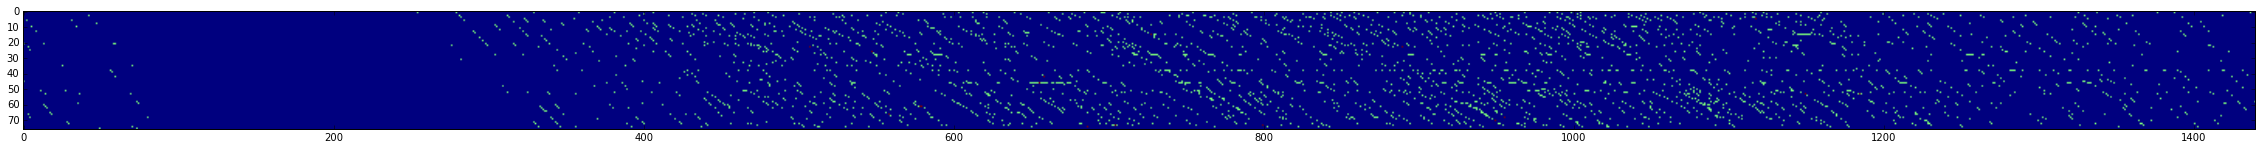

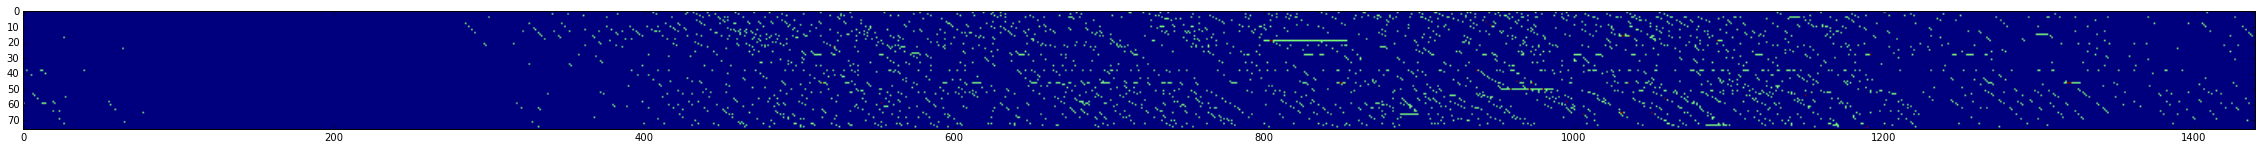

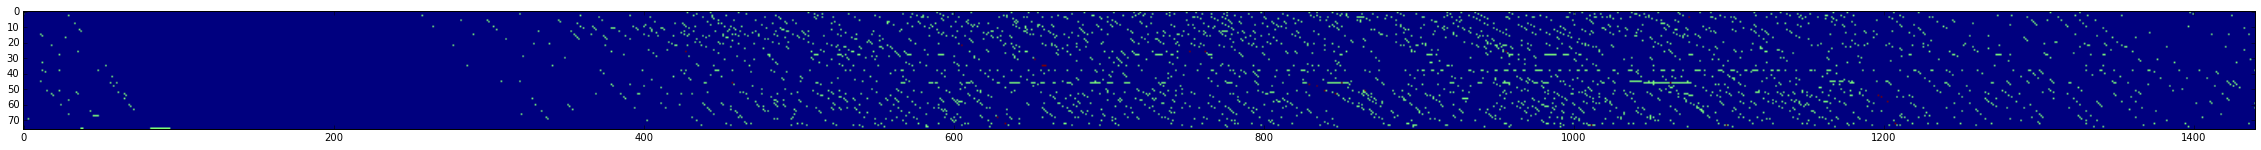

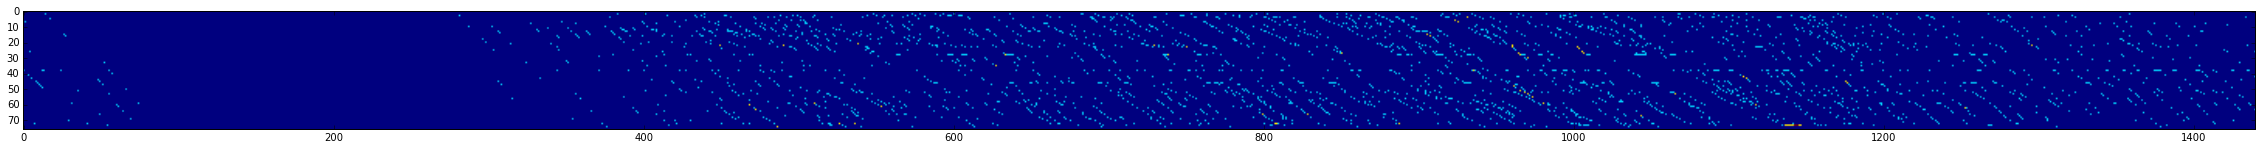

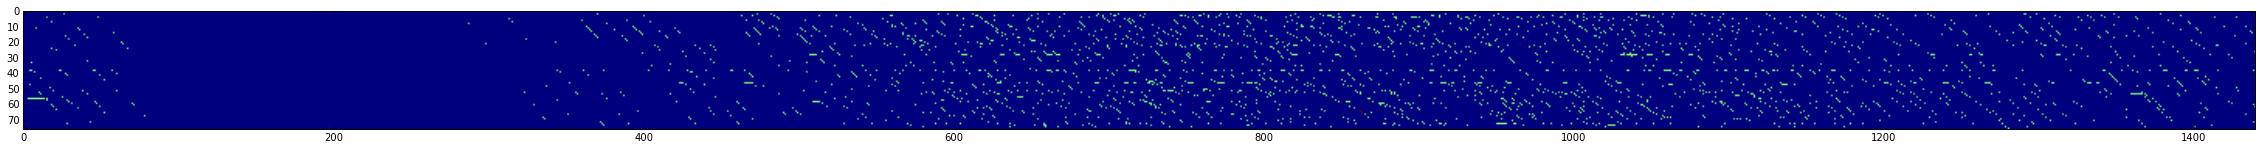

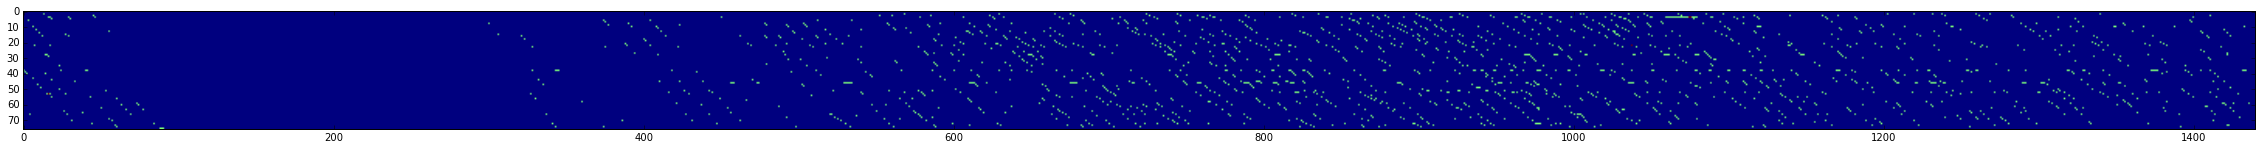

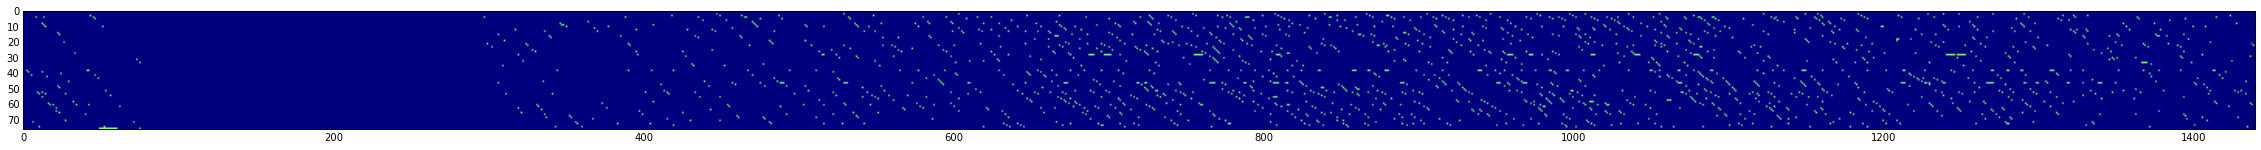

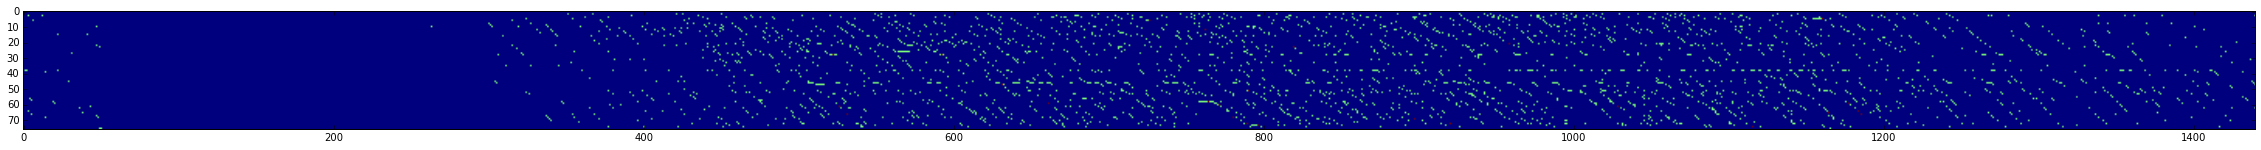

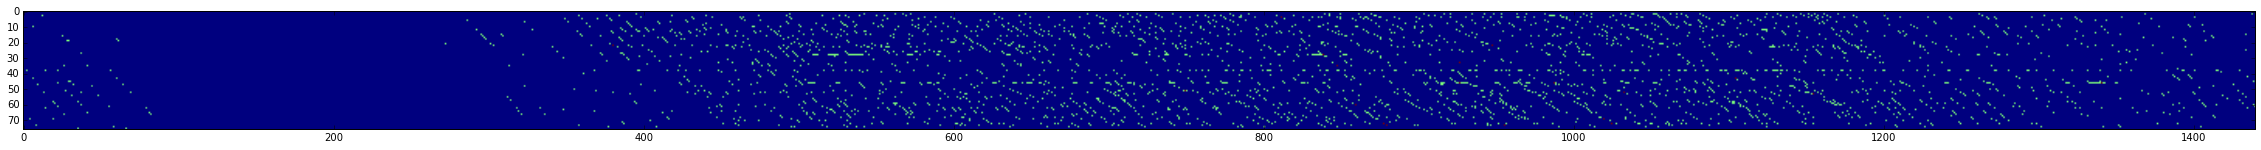

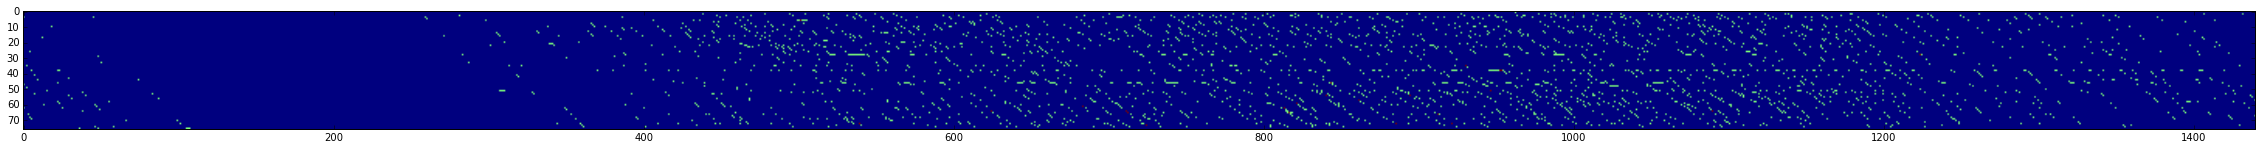

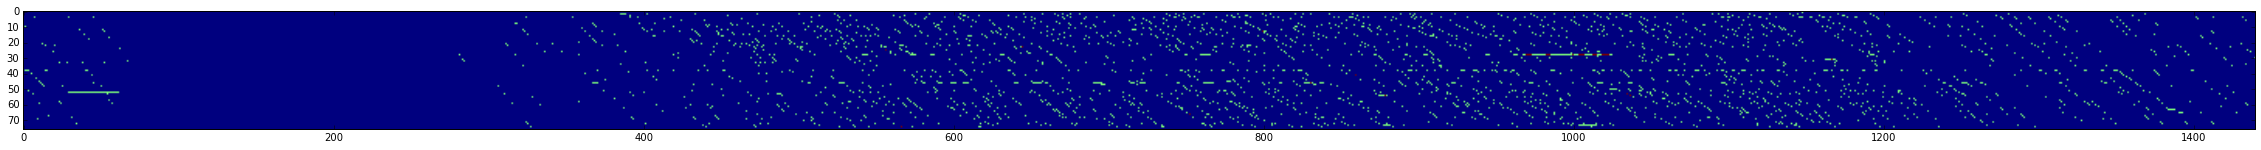

In [10]:
for i in range(30):
    figure(figsize=(40,20))
    imshow(mat[:, i*(24 * 60): (i+1) * (24 * 60)])

In [ ]:
pd.Timestamp(

In [20]:
%%timeit
np.sum(mat, axis=1)

The slowest run took 13.15 times longer than the fastest. This could mean that an intermediate result is being cached 
100 loops, best of 3: 2.61 ms per loop


In [109]:
len(df.loc[np.any(df.isnull(), axis=1)]) / float(len(df))

0.04668763878608438

In [73]:
dt1, dt2 = compute_travel_times(filter_nan_entries(df))

In [76]:
transitions = collade_transition_times(filter_nan_entries(df), dt1, dt2, ('10813', 'R0852'))

In [100]:
stop_transition_times = calculate_stop_transition_time(df)

In [87]:
[len(i) for k,i in stop_transition_times.items()]

[1,
 1,
 4759,
 2,
 4765,
 1,
 1,
 1,
 1,
 1,
 1,
 4773,
 4789,
 1,
 1,
 1,
 1,
 3,
 4872,
 4799,
 4830,
 4881,
 4593,
 2,
 1,
 7,
 40,
 4802,
 1,
 4705,
 4706,
 1,
 4887,
 4892,
 1,
 4789,
 4733,
 4802,
 1,
 4705,
 1,
 4819,
 1,
 67,
 1,
 4651,
 4677,
 4702,
 4656,
 1,
 3,
 4887,
 4651,
 2,
 4650,
 2,
 4774,
 1,
 1,
 4702,
 4652,
 66,
 2,
 1,
 4652,
 3,
 1,
 4789,
 4593,
 4652,
 4744,
 4677,
 4760,
 1,
 3,
 4813,
 4700,
 4746,
 1,
 4758,
 1,
 4647,
 4751,
 4620,
 4761,
 1,
 4891,
 4735,
 1,
 1,
 4790,
 2,
 38,
 4760,
 4701,
 1,
 4535,
 4,
 4537,
 1,
 4706,
 4651,
 2,
 1,
 4712,
 1,
 4760,
 1,
 1,
 1,
 1,
 1,
 4712,
 4700,
 1,
 4829,
 5,
 4797,
 2,
 4705,
 4791,
 1,
 1,
 1,
 1,
 2,
 1,
 4677,
 5,
 1,
 1,
 4702,
 1,
 4680,
 2,
 1,
 1,
 4737,
 8,
 1,
 1,
 18,
 4746,
 4756,
 4777,
 4749,
 4762,
 4765,
 1,
 2,
 16,
 4737,
 40,
 2,
 4706,
 4691,
 10]

ValueError: arrays must all be same length

In [86]:
stop_transition_times[('24404', '15105')]

[('30/05/2014 08:40:18', 11.0)]

In [6]:
tmp = df.iloc[np.where(np.all(np.asarray(df.iloc[:-1]["BUS_STOP_CODE"] == '10813') ==
                              np.asarray(df.iloc[1:]["BUS_STOP_CODE"] == 'R0852')))[0]+1]

In [55]:
locs = np.where(np.all(np.asarray([df.iloc[:-1]["BUS_STOP_CODE"] == start,
                              np.asarray(df.iloc[1:]["BUS_STOP_CODE"] == stop)]), axis=0))
filtered_dt1 = dt1[locs]
filtered_dt2 = dt2[locs]

filtered_dt1[filtered_dt1 == pd.NaT] = 0
filtered_dt2[filtered_dt2 == pd.NaT] = 0

times = (filtered_dt1 - filtered_dt2).astype("timedelta64[ms]").astype(int) / 1000.0

/Users/peter/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
/Users/peter/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.


In [7]:
tmp2 = df.iloc[np.all(np.asarray([df.iloc[:-1]["BUS_STOP_CODE"] == '10813',
                              np.asarray(df.iloc[1:]["BUS_STOP_CODE"] == 'R0852')]), axis=0)]

In [8]:
dt =  pd.to_datetime(df['OBSERVED_DEPARTURE_TIME']).dt.to_pydatetime()
tmp3 = (dt[:-1] - dt[1:]).astype("timedelta64[ms]").astype(int) / 1000

ValueError: Could not convert object to NumPy timedelta

In [9]:
tmp4 = (dt[:-1] - dt[1:])

In [18]:
tmp5 = tmp4[37]#.astype("timedelta64[ms]")

In [20]:
df.iloc[37]

ROUTE                                      109
DIRECTION                                    1
TRIPNR                                       5
UNSCHEDULED                                  0
SCHEDULEDDEPARTURETIME     01/05/2014 04:40:00
OBSERVED_ARRIVAL_TIME                      NaN
OBSERVED_DEPARTURE_TIME                    NaN
BUS_STOP_CODE                           BP1549
BUS_STOP_DESC                  Croydon Library
STOPSEQUENCE                                 1
SCHEDULEDDISTANCE                            0
SCHED_DIST_IN_TRIP                           0
Name: 37, dtype: object

In [21]:
df.iloc[36]

ROUTE                                      109
DIRECTION                                    1
TRIPNR                                       3
UNSCHEDULED                                  0
SCHEDULEDDEPARTURETIME     01/05/2014 04:54:00
OBSERVED_ARRIVAL_TIME      01/05/2014 04:49:46
OBSERVED_DEPARTURE_TIME    01/05/2014 04:49:46
BUS_STOP_CODE                            14622
BUS_STOP_DESC                  Brixton Station
STOPSEQUENCE                                37
SCHEDULEDDISTANCE                          295
SCHED_DIST_IN_TRIP                       11370
Name: 36, dtype: object

In [126]:
tmp3 = pd.to_datetime(df.iloc[:10]['OBSERVED_DEPARTURE_TIME'])

In [131]:
(tmp3.iloc[:-1].dt.seconds - tmp3.iloc[1:].dt.seconds)

AttributeError: 'DatetimeProperties' object has no attribute 'seconds'

In [138]:
a = tmp3.iloc[:-1].dt.to_pydatetime()

In [142]:
b = a[:1] - a[:-1]

In [153]:
c = b[1]
helper = np.vectorize(lambda x: x.total_seconds())
dt_sec = helper(b)

In [155]:
b.astype("timedelta64[ms]").astype(int) / 1000

array([   0.,  -44., -152., -233., -370., -399., -460., -497.])

In [165]:
b

array([datetime.timedelta(0), datetime.timedelta(-1, 86356),
       datetime.timedelta(-1, 86248), datetime.timedelta(-1, 86167),
       datetime.timedelta(-1, 86030), datetime.timedelta(-1, 86001),
       datetime.timedelta(-1, 85940), datetime.timedelta(-1, 85903)], dtype=object)

In [21]:
journeys = np.split(df, np.where(np.diff(df["STOPSEQUENCE"])<= 0)[0]+1)

In [39]:
list(zip(journeys[0].iloc[:-1]["BUS_STOP_CODE"], journeys[0].iloc[1:]["BUS_STOP_CODE"]))

[('BP1549', 'SL33'),
 ('SL33', '10813'),
 ('10813', 'R0852'),
 ('R0852', 'BP2000'),
 ('BP2000', '15112'),
 ('15112', '4417'),
 ('4417', '15110'),
 ('15110', '25866'),
 ('25866', '15108'),
 ('15108', '26981'),
 ('26981', '15106'),
 ('15106', '15600'),
 ('15600', '1164'),
 ('1164', '15104'),
 ('15104', '15102'),
 ('15102', '4425'),
 ('4425', '15602'),
 ('15602', '1833'),
 ('1833', '15100'),
 ('15100', '4868'),
 ('4868', '25860'),
 ('25860', 'SL37'),
 ('SL37', '4865'),
 ('4865', '2403'),
 ('2403', '36915'),
 ('36915', '25856'),
 ('25856', '1764'),
 ('1764', '25666'),
 ('25666', '43'),
 ('43', '2397'),
 ('2397', '706'),
 ('706', '707'),
 ('707', '710'),
 ('710', '2395'),
 ('2395', '24458'),
 ('24458', '14622')]

In [40]:
trans = set()

In [44]:
trans.update(list(zip(journeys[1].iloc[:-1]["BUS_STOP_CODE"], journeys[1].iloc[1:]["BUS_STOP_CODE"])))

In [47]:
trans = get_all_stop_transitions(df)

In [48]:
trans

{('10813', 'R0852'),
 ('1164', '15104'),
 ('1441', '15111'),
 ('15100', '4868'),
 ('15101', '24404'),
 ('15102', '4425'),
 ('15104', '15102'),
 ('15105', '4419'),
 ('15106', '15600'),
 ('15107', '807'),
 ('15108', '26981'),
 ('15110', '25866'),
 ('15111', '4418'),
 ('15112', '4417'),
 ('15113', '4420'),
 ('15600', '1164'),
 ('15601', '15107'),
 ('15602', '1833'),
 ('1764', '25666'),
 ('1832', '15101'),
 ('1833', '15100'),
 ('233', '2396'),
 ('2395', '24458'),
 ('2396', '4725'),
 ('2397', '706'),
 ('2398', 'R0417'),
 ('2403', '36915'),
 ('2404', '466'),
 ('24404', '25865'),
 ('24458', '14622'),
 ('25666', '43'),
 ('25856', '1764'),
 ('25860', 'SL37'),
 ('25865', 'R0543'),
 ('25866', '15108'),
 ('26408', '233'),
 ('26981', '15106'),
 ('27495', '29450'),
 ('29450', '464'),
 ('3019', '2404'),
 ('34317', 'BP2081'),
 ('35036', '474'),
 ('36915', '25856'),
 ('37002', 'R0525'),
 ('43', '2397'),
 ('4417', '15110'),
 ('4418', '15113'),
 ('4419', '15601'),
 ('4420', 'BP1916'),
 ('4425', '15602'),